<a href="https://colab.research.google.com/github/rowl27/Cancer-Omics/blob/main/01_05TCGA_PANCA_EXP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries & notebook settings

In [3]:
#!pip install cyberpunk

In [16]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')


import os # Standard library within Python 3
import numpy as np # Lib for multi-dimensional arrays and matrices handling
import pandas as pd # Lib for data manipulation and analysis
%matplotlib inline
import matplotlib.pyplot as plt # Lib for interactive plots
#plt.style.use('seaborn-white') # Sets theme of visualization (seaborn-ticks / whitegrid) are similar to white
import seaborn as sns # Matplotlib based lib - better interface for drawing attractive and informative statistical graphics
sns.set_palette(['#FC4B60','#06B1F0'])
random_seed = 63445
import warnings # Lib for warning issue handling
warnings.filterwarnings('ignore') # Ignores all irrelevant warnings
from collections import Counter
from sklearn import svm # SVM model for RFE Feature Selection
from sklearn.preprocessing import MinMaxScaler # Feature scaling
from sklearn.model_selection import train_test_split # Splitting data into training and test set
from imblearn.over_sampling import SMOTE # Oversample data using SMOTE algorithm
from sklearn.impute import SimpleImputer


import shap
import cyberpunk
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from matplotlib import gridspec
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cyberpunk_theme = {
    'axes.edgecolor': '0B2447',
    'axes.facecolor': '0B2447',
    'axes.labelcolor': 'white',
    'axes.titlecolor': 'white',
    'figure.facecolor': '0B2447',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'text.color': 'white',
    'grid.color': 'gray',
    'grid.linestyle': ':'
}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
class VAE(nn.Module):

    def __init__(self, input_dim=6561, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.device = device

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(torch.tensor(x ,dtype=torch.float32))
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

class omics():
    def __init__(self, path, kwrd,ref):
      self.path = path
      self.kwrd = kwrd
      self.ref = ref

    def get_geneexp(self):
      dt_gene = pd.read_csv(self.path + "exp", sep=' ', on_bad_lines='skip')
      dt_gene.index.names = ['PatientID']
      dat1 = np.transpose(dt_gene)
      d1 = dat1.drop_duplicates().replace(0, np.nan).dropna(axis=1,how='any',subset=None, inplace=False)
      return d1

    def get_mirna(self):
      dt_mirna  = pd.read_csv(self.path + "mirna",sep=' ',  on_bad_lines='skip')
      dat2 = np.transpose(dt_mirna)
      d2 = dat2.drop_duplicates().replace(0, np.nan).dropna(axis=1,how='any',subset=None, inplace=False)
      return d2

    def get_methy(self):
      df_methy = pd.read_csv(self.path + "methy",sep=' ',  on_bad_lines='skip')
      dat3 = np.transpose(df_methy)
      d3 = dat3.drop_duplicates().replace(0, np.nan).dropna(axis=1,how='any',subset=None, inplace=False)
      return d3

    def get_clinics(self):
      dt_clinics = pd.read_csv(self.path + self.kwrd ,sep='\t', on_bad_lines='skip')
      d0 = dt_clinics .drop_duplicates()
      d0 = d0[['sampleID','sample_type']]#
      d4=d0.replace(to_replace=["Primary Tumor","Solid Tissue Normal"],value=[self.ref,"0"])
      d4_dev=d4.rename(columns={"sampleID":"PatientID","sample_type":"Class"})
      d4_dev['PatientID']=d4_dev['PatientID'].str.replace('-','.')#.set_index('PatientID')
      d4_dev = d4_dev.set_index('PatientID')
      return d4_dev

    def get_multiomics(self):
      dframe1 = self.get_geneexp()
      dframe2 = self.get_mirna()
      dframe3 = self.get_methy()
      dframe4 = self.get_clinics()
      integrate = [dframe1,dframe2,dframe3,dframe4]
      return pd.concat(integrate, axis=1, join='inner')
    def get_meth_cl(self):

      dframe3 = self.get_methy()
      dframe4 = self.get_clinics()
      integrate = [dframe3,dframe4]
      return pd.concat(integrate, axis=1, join='inner')

    def get_gene_cl(self):

      dframe1 = self.get_geneexp()
      dframe4 = self.get_clinics()
      integrate = [dframe1,dframe4]
      return pd.concat(integrate, axis=1, join='inner')


def prep_loaders(features, target):
  x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)
  x_train_tensor = torch.tensor(x_train.values)
  y_train_tensor = torch.tensor(y_train.values)
  train = data_utils.TensorDataset(x_train_tensor, y_train_tensor)
  train_loader = data_utils.DataLoader(train, batch_size=10, shuffle=True)

  x_train_tensor = torch.tensor(x_train.values)
  y_train_tensor = torch.tensor(y_train.values)
  train = data_utils.TensorDataset(x_train_tensor, y_train_tensor)
  train_loader = data_utils.DataLoader(train, batch_size=10, shuffle=True)
  x_test_tensor = torch.tensor(x_test.values)
  y_test_tensor = torch.tensor(y_test.values)
  test = data_utils.TensorDataset(x_test_tensor, y_test_tensor)
  test_loader = data_utils.DataLoader(test, batch_size=10, shuffle=True)

  x_test_tensor = torch.tensor(x_test.values)
  y_test_tensor = torch.tensor(y_test.values)
  test = data_utils.TensorDataset(x_test_tensor, y_test_tensor)
  test_loader = data_utils.DataLoader(test, batch_size=10, shuffle=True)
  return train_loader, test_loader,x_train, x_test, y_train, y_test



def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x_shape = tuple(x.shape)
           # print(x_shape)
            batch_size = x_shape[0]
            x = x.type(torch.float32).view(x_shape).to(device)
            #x = x.view(x_shape).to(device)
            #x = x.view(batch_size, x_shape).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss


Dataset Aggregation

In [62]:
root_path='/content/drive/MyDrive/DOC_UPM/datasets/'
omics_data ={'BRECA':{'local_path':'01_004_BRECA', 'kwrd':'breast','key':'2'},\
       'GBM': {'local_path':'01_005_GBM', 'kwrd':'gbm','key':'3'},\
        'LUSC': {'local_path':'01_003_LUSC','kwrd': 'lung','key':'1'},\
        'SRCM': {'local_path':'01_007_SRCM','kwrd': 'sarcoma','key':'4'},\
             'AML': {'local_path':'01_008_AML','kwrd': 'aml','key':'5'},\
             'LIVER': {'local_path':'01_006_LIVER','kwrd': 'liver','key':'6'}\

             }
#Cancer Included
cacer_list=['BRECA','GBM','LUSC','SRCM','AML','LIVER']

In [63]:
f1='BRECA'
local_path=omics_data[f1]['local_path'] # use omics_data instead of omics
path= '%(root_path)s%(local_path)s/'% locals()
breca_omics= omics(path,omics_data[f1]['kwrd'],omics_data[f1]['key']).get_gene_cl()
f1='LUSC'
local_path=omics_data[f1]['local_path'] # use omics_data instead of omics
path= '%(root_path)s%(local_path)s/'% locals()
lusc_omics= omics(path,omics_data[f1]['kwrd'],omics_data[f1]['key']).get_gene_cl()
f1='GBM'
local_path=omics_data[f1]['local_path'] # use omics_data instead of omics
path= '%(root_path)s%(local_path)s/'% locals()
gbm_omics= omics(path,omics_data[f1]['kwrd'],omics_data[f1]['key']).get_gene_cl()
f1='SRCM'
local_path=omics_data[f1]['local_path'] # use omics_data instead of omics
path= '%(root_path)s%(local_path)s/'% locals()
srcm_omics= omics(path,omics_data[f1]['kwrd'],omics_data[f1]['key']).get_gene_cl()
f1='AML'
local_path=omics_data[f1]['local_path'] # use omics_data instead of omics
path= '%(root_path)s%(local_path)s/'% locals()
aml_omics= omics(path,omics_data[f1]['kwrd'],omics_data[f1]['key']).get_gene_cl()
f1='LIVER'
local_path=omics_data[f1]['local_path'] # use omics_data instead of omics
path= '%(root_path)s%(local_path)s/'% locals()
liver_omics= omics(path,omics_data[f1]['kwrd'],omics_data[f1]['key']).get_gene_cl()

In [118]:
inter_ca= [srcm_omics[srcm_omics['Class']!='Metastatic'],liver_omics[liver_omics['Class']!='Metastatic'],gbm_omics[gbm_omics['Class']!='Metastatic'],aml_omics[aml_omics['Class']!='Metastatic'],breca_omics[breca_omics['Class']!='Metastatic'],lusc_omics[lusc_omics['Class']!='Metastatic']]
df_pan=pd.concat(inter_ca, join="outer").reset_index()
df_pan = df_pan[~df_pan['Class'].isin(['Recurrent Tumor','Primary Blood Derived Cancer - Peripheral Blood'])]

df_pan.shape


(2977, 39625)

In [119]:
df_pan['Class'].value_counts()

,count
Class,
2,1093
3,528
1,501
6,371
4,259
0,225


Normalization and Missing Values Imputation

In [125]:
features = df_pan.drop(columns=['Class','index']) #Retrieves all rows (1:), leaves last column (,1:-1)
features=features.dropna(axis=1, how='all')
target = df_pan['Class'].astype('int32') #Retrieves all rows (1:), leaves last column (,1:-1)
nfeatures=len(features.columns)
min_max_scaler = MinMaxScaler(feature_range =(0, 1))
#Scaled feature
features = pd.DataFrame(min_max_scaler.fit_transform(features), columns=features.columns, index=features.index)
imputer = SimpleImputer(strategy='mean')
imputer.fit(features)
features_imputed = imputer.transform(features)
current_columns = features.columns
features = pd.DataFrame(features_imputed, columns=current_columns)



Dimensionality Reduction

##### **Shap**

In [18]:
#Shap filering
##[filer_list]
features.shape

(2004, 16408)

##### **SVM Correlation**

In [ ]:
#Set Parameter
C = 1.0
rfeIndex = nfeatures
#Create SVM model using a linear kernel
model = svm.SVC(kernel='linear', C=C).fit(features,target)
coef = model.coef_
#Print co-efficients of features
#for i in range(0, nFeatures):
#	print (features.columns[i],":", coef[0][i])
#Find the minimum weight among features and eliminate the feature with the smallest weight
nFeatures= nfeatures
min1 = coef[0][0]

for j in range(12000): # To make sure only 12,000 features remain
  index = 0
  j+=1
  for i in range(0, rfeIndex): # Iterates until the final feature
	  if min1 > coef[0][i]:
		  index = index + 1
		  min1 = coef[0][i]

  if len(features.columns) == 1:
	  #print ("After recursive elimination we have the", features.columns[index], "feature with a score of:", min)
    at2=1
  else:
	  #print ("Lowest feature weight is for", features.columns[index], "with a value of:", min)
	  #print ("Dropping feature", features.columns[index])
	  features.drop(features.columns[index], axis = 1, inplace = True)
	  rfeIndex = rfeIndex - 1
	  nFeatures = nFeatures - 1

ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

SMOTE Balancing

Dataloaders Production

In [126]:
  x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

  x_train_tensor = torch.tensor(x_train.values)
  y_train_tensor = torch.tensor(y_train.values)
  train = data_utils.TensorDataset(x_train_tensor, y_train_tensor)
  train_loader = data_utils.DataLoader(train, batch_size=10, shuffle=True)

  x_test_tensor = torch.tensor(x_test.values)
  y_test_tensor = torch.tensor(y_test.values)
  test = data_utils.TensorDataset(x_test_tensor, y_test_tensor)
  test_loader = data_utils.DataLoader(test, batch_size=10, shuffle=True)



In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_n = RandomForestClassifier(n_estimators=5, random_state=random_seed)
rf_n.fit(x_train, y_train)
y_pred= rf_n.predict(x_test)

explainer = shap.TreeExplainer(rf_n)
shap_values = explainer.shap_values(x_test)
feature_names = x_test.columns


X = pd.DataFrame(shap_values[:,:,0], columns = feature_names)
X1 = pd.DataFrame(shap_values[:,:,1], columns = feature_names)
X2 = pd.DataFrame(shap_values[:,:,2], columns = feature_names)
X3 = pd.DataFrame(shap_values[:,:,3], columns = feature_names)
X4 = pd.DataFrame(shap_values[:,:,4], columns = feature_names)

rf_resultX = pd.concat([X,X1,X2,X3,X4], axis=1)
vals = np.abs(rf_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
filer_list =shap_importance['col_name'].head(20000)

In [ ]:
x_test

,X..10357,X..10431,X..155060,X..57714,X..653553,X..8225,A1BG.1,A2LD1.87769,A2M.2,A4GALT.53947,...,cg27538352,cg27546977,cg27553926,cg27577527,cg27583037,cg27592331,cg27623451,cg27633287,cg27645259,cg27649037
567,0.307366,0.306280,0.129455,0.143689,0.056584,0.130892,0.090497,0.098057,0.136680,0.091603,...,0.677663,0.559062,0.609504,0.209322,0.292374,0.554306,0.598948,0.551992,0.216923,0.473643
1324,0.307366,0.306280,0.129455,0.143689,0.056584,0.130892,0.090497,0.098057,0.136680,0.091603,...,0.677663,0.559062,0.609504,0.209322,0.292374,0.554306,0.598948,0.551992,0.216923,0.473643
1631,0.307366,0.306280,0.129455,0.143689,0.056584,0.130892,0.090497,0.098057,0.136680,0.091603,...,0.460646,0.677230,0.684504,0.811570,0.017338,0.760510,0.299355,0.335235,0.018136,0.343955
115,0.352497,0.156482,0.045295,0.090760,0.007435,0.055608,0.189713,0.061949,0.074484,0.018168,...,0.677663,0.559062,0.609504,0.209322,0.292374,0.554306,0.598948,0.551992,0.216923,0.473643
453,0.307366,0.306280,0.129455,0.143689,0.056584,0.130892,0.090497,0.098057,0.136680,0.091603,...,0.677663,0.559062,0.609504,0.209322,0.292374,0.554306,0.598948,0.551992,0.216923,0.473643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1432,0.307366,0.306280,0.129455,0.143689,0.056584,0.130892,0.090497,0.098057,0.136680,0.091603,...,0.354718,0.745298,0.252804,0.001602,0.028159,0.697594,0.724312,0.427979,0.016590,0.938279
277,0.078597,0.152623,0.061526,0.097989,0.055339,0.188868,0.213485,0.056247,0.049543,0.062027,...,0.677663,0.559062,0.609504,0.209322,0.292374,0.554306,0.598948,0.551992,0.216923,0.473643
1320,0.307366,0.306280,0.129455,0.143689,0.056584,0.130892,0.090497,0.098057,0.136680,0.091603,...,0.677663,0.559062,0.609504,0.209322,0.292374,0.554306,0.598948,0.551992,0.216923,0.473643
1569,0.307366,0.306280,0.129455,0.143689,0.056584,0.130892,0.090497,0.098057,0.136680,0.091603,...,0.991416,0.382739,0.587808,0.407970,0.640693,0.626473,0.389477,0.604402,0.041255,0.465196


In [127]:
import torch.optim as optim
model = VAE( input_dim=features.shape[1], hidden_dim=400, latent_dim=200, device=device).to(device)#[filer_list].
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
#Check device
device

device(type='cuda')

In [ ]:
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        # Use train_loader instead of train
        for batch_idx, (x, _) in enumerate(train_loader):
            x_shape = tuple(x.shape)
            batch_size = x_shape[0]
            x = x.type(torch.float32).view(x_shape).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss
train(model, optimizer, epochs=50, device=device)

	Epoch 1 	Average Loss:  90420.88145494675
	Epoch 2 	Average Loss:  88719.84725336323
	Epoch 3 	Average Loss:  88522.46221622758
	Epoch 4 	Average Loss:  88382.90226492433
	Epoch 5 	Average Loss:  88337.36617152467
	Epoch 6 	Average Loss:  88309.68932174888
	Epoch 7 	Average Loss:  88302.58855626402
	Epoch 8 	Average Loss:  88250.99216998319
	Epoch 9 	Average Loss:  88212.24009424046
	Epoch 10 	Average Loss:  88301.73736161715
	Epoch 11 	Average Loss:  88128.32716157511
	Epoch 12 	Average Loss:  88294.47316423767
	Epoch 13 	Average Loss:  88168.28414903308
	Epoch 14 	Average Loss:  88069.76514328756


<Axes: xlabel='dim1', ylabel='dim2'>

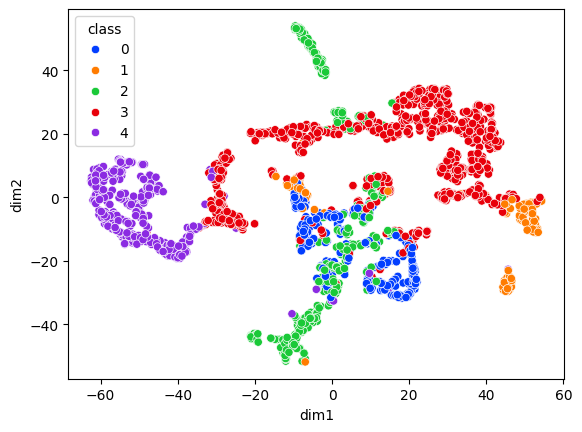

In [48]:
from sklearn.manifold import TSNE
x_encoded = model.encode(torch.tensor(x_train.head(1).values, dtype=torch.float32).to(device))
x_hat, mean, logvar = model(torch.tensor(x_train.values, dtype=torch.float32).to(device))
embg200=x_hat.detach().cpu().numpy()
tsne = TSNE(n_components = 2, random_state=0)
tsne_res = tsne.fit_transform(embg200)
toPlot=pd.DataFrame({'dim1':tsne_res[:, 0],'dim2':tsne_res[:, 1],'class':y_train})
import seaborn as sns
sns.scatterplot(data=toPlot, x="dim1", y="dim2", hue="class", palette='bright')

In [73]:
x_encoded = model.encode(torch.tensor(x_test.values, dtype=torch.float32).to(device))
x_hat, mean, logvar = model(torch.tensor(x_test.values, dtype=torch.float32).to(device))
embg200=x_hat.detach().cpu().numpy()

<Axes: xlabel='dim1', ylabel='dim2'>

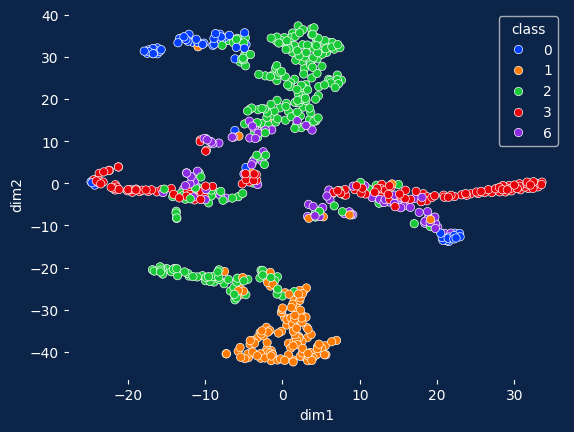

In [74]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, random_state=0)
tsne_res = tsne.fit_transform(embg200)
toPlot=pd.DataFrame({'dim1':tsne_res[:, 0],'dim2':tsne_res[:, 1],'class':y_test.values})
import seaborn as sns
sns.scatterplot(data=toPlot, x="dim1", y="dim2", hue="class", palette='bright')

In [75]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=5, random_state=random_seed)
# Move x_hat and y_test_tensor to CPU before converting to NumPy arrays
rf.fit(x_hat.cpu().detach().numpy(), y_test_tensor.cpu().detach().numpy())

y_pred= rf.predict(x_hat.cpu().detach().numpy())
# Calculate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Generate classification report
report = classification_report(y_test, y_pred)
print(report)

Accuracy: 0.9735
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        59
           1       0.99      0.95      0.97       130
           2       0.97      0.99      0.98       265
           3       0.98      0.99      0.98       136
           6       0.96      0.92      0.94        89

    accuracy                           0.97       679
   macro avg       0.97      0.97      0.97       679
weighted avg       0.97      0.97      0.97       679



NOT VAE

In [76]:
from sklearn.ensemble import RandomForestClassifier
rf_n = RandomForestClassifier(n_estimators=5, random_state=random_seed)
rf_n.fit(x_train, y_train)
y_pred= rf_n.predict(x_test)
# Calculate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Generate classification report
report = classification_report(y_test, y_pred)
print(report)

Accuracy: 0.9853
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        59
           1       1.00      0.99      1.00       130
           2       0.99      1.00      0.99       265
           3       1.00      0.99      1.00       136
           6       0.98      0.98      0.98        89

    accuracy                           0.99       679
   macro avg       0.98      0.97      0.98       679
weighted avg       0.99      0.99      0.99       679



Shap

In [ ]:
rf_resultX

,X..10357,X..10431,X..155060,X..57714,X..653553,X..8225,A1BG.1,A2LD1.87769,A2M.2,A4GALT.53947,...,cg27538352,cg27546977,cg27553926,cg27577527,cg27583037,cg27592331,cg27623451,cg27633287,cg27645259,cg27649037
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(x_test)
feature_names = x_test.columns


In [57]:
shap_values .shape

(679, 37594, 5)

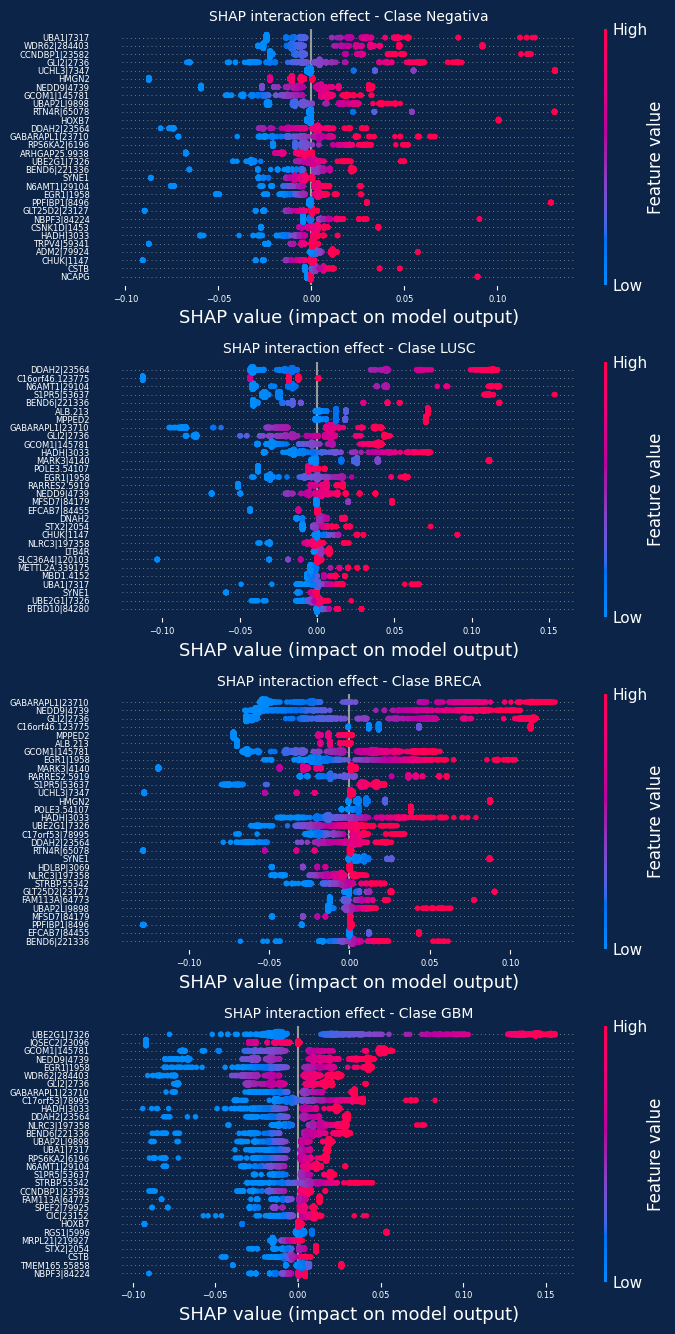

In [82]:
plt.style.use(cyberpunk_theme)
fig = plt.figure(tight_layout=True, figsize=(10, 5))
spec = gridspec.GridSpec(ncols=1, nrows=4, figure=fig)  # Ajustado a una sola fila para visualización en paralelo

ax1 = fig.add_subplot(spec[0, 0])  # ax1 en la primera columna
shap.summary_plot(shap_values[:, :, 0], features=shap_values[:, :, 0], feature_names=x_test.columns, max_display=30, axis_color='w', show=False)  # show=False para evitar que se muestre antes de tiempo
ax1.yaxis.label.set_color('white')
ax1.xaxis.label.set_color('white')
ax1.tick_params(axis='x', colors='white', labelsize=6)
ax1.tick_params(axis='y', colors='white', labelsize=6)
ax1.set_title(f'SHAP interaction effect - Clase Negativa', fontsize=10)  # Título para ax1

ax2 = fig.add_subplot(spec[1, 0])  # ax2 en la segunda columna
shap.summary_plot(shap_values[:, :, 1], features=shap_values[:, :, 1], feature_names=x_test.columns, max_display=30, axis_color='w', show=False)  # show=False para evitar que se muestre antes de tiempo
ax2.yaxis.label.set_color('white')
ax2.xaxis.label.set_color('white')
ax2.tick_params(axis='x', colors='white', labelsize=6)
ax2.tick_params(axis='y', colors='white', labelsize=6)
ax2.set_title(f'SHAP interaction effect - Clase LUSC', fontsize=10)  # Título para ax2

ax3 = fig.add_subplot(spec[2, 0])  # ax2 en la segunda columna
shap.summary_plot(shap_values[:, :, 2], features=shap_values[:, :, 2], feature_names=x_test.columns, max_display=30, axis_color='w', show=False)  # show=False para evitar que se muestre antes de tiempo
ax3.yaxis.label.set_color('white')
ax3.xaxis.label.set_color('white')
ax3.tick_params(axis='x', colors='white', labelsize=6)
ax3.tick_params(axis='y', colors='white', labelsize=6)
ax3.set_title(f'SHAP interaction effect - Clase BRECA', fontsize=10)  # Título para ax2

ax4 = fig.add_subplot(spec[3, 0])  # ax2 en la segunda columna
shap.summary_plot(shap_values[:, :, 3], features=shap_values[:, :, 3], feature_names=x_test.columns, max_display=30, axis_color='w', show=False)  # show=False para evitar que se muestre antes de tiempo
ax4.yaxis.label.set_color('white')
ax4.xaxis.label.set_color('white')
ax4.tick_params(axis='x', colors='white', labelsize=6)
ax4.tick_params(axis='y', colors='white', labelsize=6)
ax4.set_title(f'SHAP interaction effect - Clase GBM', fontsize=10)  # Títu


plt.show()


In [113]:
import pandas as pd

# Calcular el promedio absoluto de los valores de SHAP para cada feature y clase
mean_abs_shap_class1 = np.mean(np.abs(shap_values[:, :, 0]), axis=0)
mean_abs_shap_class2 = np.mean(np.abs(shap_values[:, :, 1]), axis=0)
mean_abs_shap_class3 = np.mean(np.abs(shap_values[:, :, 2]), axis=0)
mean_abs_shap_class4 = np.mean(np.abs(shap_values[:, :, 3]), axis=0)
mean_abs_shap_class5 = np.mean(np.abs(shap_values[:, :, 4]), axis=0)


# Crear un DataFrame con los promedios absolutos
shap_df_mean_abs = pd.DataFrame({
    'Clase 1': mean_abs_shap_class1,
    'Clase 2': mean_abs_shap_class2,
    'Clase 3': mean_abs_shap_class3,
    'Clase 4': mean_abs_shap_class4,
    'Clase 5': mean_abs_shap_class5
}, index=x_test.columns)

# Renombrar el índice a 'Feature'
shap_df_mean_abs.index.name = 'Feature'

# Mostrar el DataFrame resultante
df1 = shap_df_mean_abs
df2 = shap_df_mean_abs.sort_values(by='Clase 2', ascending=False)['Clase 2'].head(50)
df3 = shap_df_mean_abs.sort_values(by='Clase 3', ascending=False)['Clase 3'].head(50)
df4 = shap_df_mean_abs.sort_values(by='Clase 4', ascending=False)['Clase 4'].head(50)
df5 = shap_df_mean_abs.sort_values(by='Clase 5', ascending=False)['Clase 5'].head(50)

In [114]:
df5.head(10)

,Clase 5
Feature,
IQSEC2|23096,0.038832
UBE2G1|7326,0.037184
GLI2|2736,0.022276
N6AMT1|29104,0.018156
RARRES2.5919,0.013339
HDLBP|3069,0.012275
CCNDBP1|23582,0.011914
C17orf53|78995,0.011375
GABARAPL1|23710,0.010553


In [ ]:
shap_values.shape

(427, 59819, 5)

In [115]:
import pandas as pd

# Calcular el promedio absoluto de los valores de SHAP para cada feature y clase
mean_abs_shap_class1 = np.mean(np.abs(shap_values[:, :, 0]), axis=0)
mean_abs_shap_class2 = np.mean(np.abs(shap_values[:, :, 1]), axis=0)
mean_abs_shap_class3 = np.mean(np.abs(shap_values[:, :, 2]), axis=0)
mean_abs_shap_class4 = np.mean(np.abs(shap_values[:, :, 3]), axis=0)
mean_abs_shap_class5 = np.mean(np.abs(shap_values[:, :, 4]), axis=0)






# Crear un DataFrame con los promedios absolutos
shap_df_mean_abs = pd.DataFrame({
    'Clase 1': mean_abs_shap_class1,
    'Clase 2': mean_abs_shap_class2,
    'Clase 3': mean_abs_shap_class3,
    'Clase 4': mean_abs_shap_class4,
    'Clase 5': mean_abs_shap_class5
}, index=x_test.columns)

# Renombrar el índice a 'Feature'
shap_df_mean_abs.index.name = 'Feature'
shap_df_mean_abs['tot']=shap_df_mean_abs.median(axis=1)


IndexError: index 5 is out of bounds for axis 2 with size 5

In [105]:
shap_con= shap_df_mean_abs.sort_values(by='tot', ascending=False).head(50)

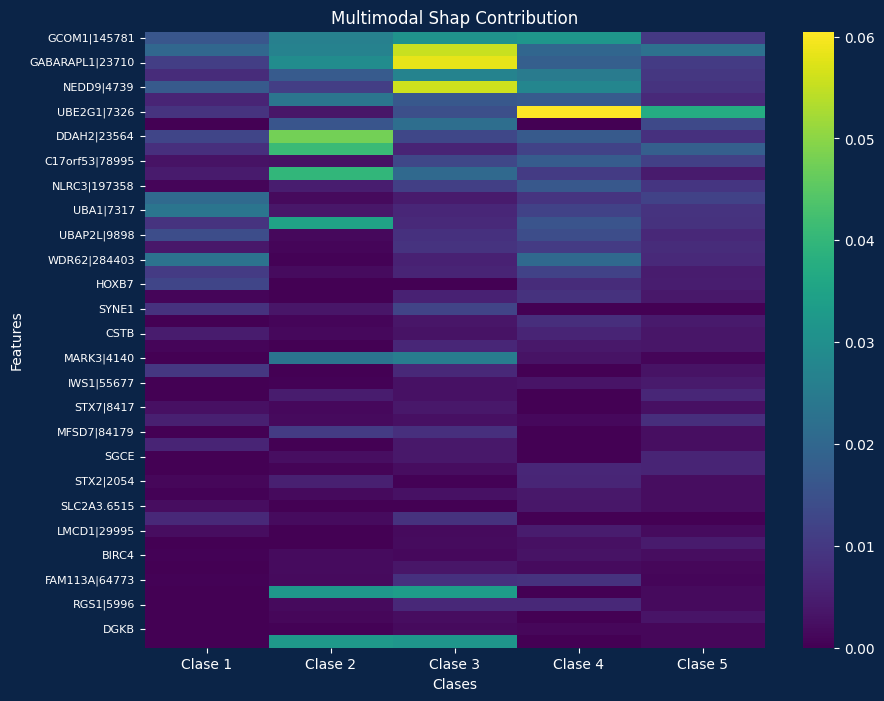

In [106]:
plt.figure(figsize=(10, 8))  # Ajustar el tamaño de la figura si es necesario
sns.heatmap(shap_con.drop('tot',axis=1), annot=False, cmap='viridis', fmt=".2f")  # Personalizar opciones

plt.title('Multimodal Shap Contribution')
plt.xlabel('Clases')
plt.ylabel('Features')
plt.yticks(fontsize=8)
plt.show()

In [ ]:
x_test.shape

(427, 20000)

In [ ]:
shap_interaction = explainer.shap_interaction_values(x_test.values.astype(np.float32))

In [ ]:
shap_interaction = shap_interaction.astype(np.float32)
mean_shap = np.abs(shap_interaction[:,1,1]).mean(0)